In [9]:
import json
import csv
import re
from tqdm import tqdm

import pandas as pd

import spacy
from spacy import displacy
from spacy.matcher import Matcher 
from spacy.tokens import Span

import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

nlp_small = spacy.load('en_core_web_sm')
nlp_large = spacy.load("en_core_web_lg")

In [10]:
dataset = r"../data/input/restaurant_data.json"

# read restaurant knowledgebase data
knowledge_base_entities = r"../data/kb/entities/"
kb_restaurant_file = knowledge_base_entities + "restaurant.csv"
kb_menu_file = knowledge_base_entities + "menu.csv"
kb_general_file = knowledge_base_entities + "general.csv"
kb_restaurant_aspects_file = knowledge_base_entities + "restaurant_aspects.csv"
kb_menu_aspects_file = knowledge_base_entities + "menu_aspects.csv"

entity_headers = ['Name', 'Label']

kb_restaurant_df = pd.read_csv(kb_restaurant_file, header=0, names=entity_headers)
kb_menu_df = pd.read_csv(kb_menu_file, header=0, names=entity_headers)
# kb_general_df = pd.read_csv(kb_general_file, header=0, names=['Name', 'Label'])
kb_restaurant_aspects_df = pd.read_csv(kb_restaurant_aspects_file, header=0, names=entity_headers)
kb_menu_aspects_df = pd.read_csv(kb_menu_aspects_file, header=0, names=entity_headers)
print(kb_restaurant_df)

f = open(dataset,)
dataset = json.load(f)
f.close()

                      Name       Label
0  Silver spoon Restaurant  RESTAURANT


In [11]:
# credit: https://github.com/wang-h/bert-relation-classification/blob/master/utils.py 
def clean_str(text):
#     text = text.lower()
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=<>]", " ", text)
    text = re.sub(r"[0-9]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"that's", "that is ", text)
    text = re.sub(r"there's", "there is ", text)
    text = re.sub(r"it's", "it is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
#     text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

In [12]:
# credit: https://github.com/wang-h/bert-relation-classification/blob/master/utils.py 
def replace_subject_entity(text, entity):
    text = re.sub(r"\bI\b|\bi\b|\bWe\b|\bwe\b", entity, text)
    return text

In [13]:
restaurants = []
restaurants.extend(restaurant for restaurant in dataset["restaurants"])

for restaurant in restaurants:
    for review in restaurant["reviews"]:
        print(review["review"])
        review["review"] = clean_str(review["review"])
        review["review"] = replace_subject_entity(review["review"], review["name"])
        print(review["review"])

I usually visit silver spoon restaurant with my friends. Their food quality is amazing and I like their chicken biryani a lot. Its so delicious. Their food as well as services are all good.
Angela usually visit silver spoon restaurant with my friends. Their food quality is amazing and Angela like their chicken biryani a lot. Its so delicious. Their food as well as services are all good.
Amazing goat briyani. Huge portions that can easily last for two times. However, it was so tasty that I over ate the whole briyani in one go. The price is very reasonable and briyani had lot of meat prices. Didn't like their chicken qourma. As it lacked taste and was bland. Staff is decent and service is quick. Will definitely be regular here just and just for briyani.
Amazing goat briyani. Huge portions that can easily last for two times. However it was so tasty that Gautram over ate the whole briyani in one go. The price is very reasonable and briyani had lot of meat prices. Did not like their chicken

In [16]:
import os, sys
sys.path.append("../")

from resolve_coreference import AllenCR

allen_cr = AllenCR(True)
predictor, nlp = allen_cr.load_models()

for restaurant in restaurants:
    for review in restaurant["reviews"]:
        dummy_sentence = review["name"]+" visit "+restaurant["name"]+"."
        doc = dummy_sentence+" "+review["review"]
        
        clusters = predictor.predict(doc)['clusters']
        nlp_doc = nlp(doc)
        # allen_cr.print_comparison(allen_cr.original_replace_corefs(nlp_doc, clusters),
        #                            allen_cr.improved_replace_corefs(nlp_doc, clusters))
        # coref_resolved = allen_cr.original_replace_corefs(nlp_doc, clusters)
        coref_resolved = allen_cr.improved_replace_corefs(nlp_doc, clusters)

        doc = coref_resolved

        ## split doc into sentences and remove first sentence
        # nlp_small.add_pipe(nlp_small.create_pipe('sentencizer'))
        nlp_doc = nlp_small(doc)
        sentences = [sent.string.strip() for sent in nlp_doc.sents]
        ## remove dumy_sentence
        sentences.pop(0)
        rev = " ".join([sent for sent in sentences])
        review["review"] = rev
        print(rev)

[AllenCR] Initializing...
[AllenCR] Loading model from: https://storage.googleapis.com/allennlp-public-models/coref-spanbert-large-2020.02.27.tar.gz


Some weights of BertModel were not initialized from the model checkpoint at SpanBERT/spanbert-large-cased and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[AllenCR] Model loaded successfully...
Angela usually visit Silver spoon restaurant with Angela's friends. Silver spoon restaurant's food quality is amazing and Angela like Silver spoon restaurant's chicken biryani a lot. their chicken biryani's so delicious. Silver spoon restaurant's food as well as services are all good.
Amazing goat briyani. Huge portions that can easily last for two times. However Amazing goat briyani. was so tasty that Gautram over ate Amazing goat briyani. in one go. The price is very reasonable and briyani had lot of meat prices. Did not like Silver spoon restaurant's chicken qourma. As their chicken qourma lacked taste and was bland. Staff is decent and service is quick. Will definitely be regular here just and just for briyani.
food tasted soo bad ! soo salty Maya could not even eat food. chicken briyani and chicken kebab were so salty. chicken kebabs were not cooked properly too. never again order from these people. Maya called these people and told these peo

In [17]:
print(restaurants)

[{'rest_id': '0', 'name': 'Silver spoon restaurant', 'address': '1548 Warden Avenue Toronto, ON M1R 2S8 Scarborough', 'reviews': [{'reviewer_id': 'ssr_1', 'name': 'Angela', 'rating': '5', 'review': "Angela usually visit Silver spoon restaurant with Angela's friends. Silver spoon restaurant's food quality is amazing and Angela like Silver spoon restaurant's chicken biryani a lot. their chicken biryani's so delicious. Silver spoon restaurant's food as well as services are all good."}, {'reviewer_id': 'ssr_2', 'name': 'Gautram', 'rating': '4', 'review': "Amazing goat briyani. Huge portions that can easily last for two times. However Amazing goat briyani. was so tasty that Gautram over ate Amazing goat briyani. in one go. The price is very reasonable and briyani had lot of meat prices. Did not like Silver spoon restaurant's chicken qourma. As their chicken qourma lacked taste and was bland. Staff is decent and service is quick. Will definitely be regular here just and just for briyani."}, 

In [18]:
## Make reviews string
for restaurant in restaurants:
    reviews = []
    for review in restaurant["reviews"]:
        reviews.append(review["review"])
    restaurant["review_str"] = " ".join(review for review in reviews)

# print(restaurants)

In [19]:
from spell_check import levenshtein_ratio_and_distance

## Create entity file
for restaurant in restaurants:
    reviews = []
    if restaurant["reviews"] and len(restaurant["reviews"]) > 0:

        for review in restaurant["reviews"]:
            reviews.append(review["review"])

        reviews_str = " ".join(review for review in reviews)
        doc = nlp_large(reviews_str)

        ner_dict = {}
        for x in doc.ents:
            entity_span = x.text
            
            has_restaurant_entity = False
            i = 0
            for restaurant in kb_restaurant_df['Name']:
                ratio = levenshtein_ratio_and_distance(restaurant.lower(), entity_span.lower(), ratio_calc=True)
                if ratio > 0.85:
                    has_restaurant_entity = True
                if has_restaurant_entity:
                    break
                i += 1

            if has_restaurant_entity:
                continue
                
            has_menu_entity = False
            i = 0
            for menu in kb_menu_df['Name']:
                ratio = levenshtein_ratio_and_distance(menu.lower(), entity_span.lower(), ratio_calc=True)
                #print(menu.lower(), entity_span.lower(), str(ratio))
                if ratio > 0.85:
                    has_menu_entity = True
                if has_menu_entity:
                    break
                i += 1

            if has_menu_entity:
                continue

            ner_dict[x.text] = x.label_

        ner_dict

        with open(kb_general_file, 'a') as f_object:
            dictwriter_object = csv.writer(f_object)
            for key, value in ner_dict.items():
                dictwriter_object.writerow([key, value])
            f_object.close()

            # opening the csv file in 'w' mode
        general_file = open(kb_general_file, 'w')

        with general_file:
            writer = csv.DictWriter(general_file, fieldnames=entity_headers)

            writer.writeheader()
            for key, value in ner_dict.items():
                writer.writerow({entity_headers[0]: key,
                                entity_headers[1]: value})


In [20]:
print(doc)

Angela usually visit Silver spoon restaurant with Angela's friends. Silver spoon restaurant's food quality is amazing and Angela like Silver spoon restaurant's chicken biryani a lot. their chicken biryani's so delicious. Silver spoon restaurant's food as well as services are all good. Amazing goat briyani. Huge portions that can easily last for two times. However Amazing goat briyani. was so tasty that Gautram over ate Amazing goat briyani. in one go. The price is very reasonable and briyani had lot of meat prices. Did not like Silver spoon restaurant's chicken qourma. As their chicken qourma lacked taste and was bland. Staff is decent and service is quick. Will definitely be regular here just and just for briyani. food tasted soo bad ! soo salty Maya could not even eat food. chicken briyani and chicken kebab were so salty. chicken kebabs were not cooked properly too. never again order from these people. Maya called these people and told these people this and these people did not even 

Starting server with command: java -Xmx8G -cp /home/muzamil/.stanfordnlp_resources/stanford-corenlp-4.1.0/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-af61cffea14c44f0.props -preload openie
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[('Angela', 'PERSON'), ('Angela', 'PERSON'), ('Silver', 'LOC')]
[['Angela', visit, 'Silver spoon restaurant'],
 ['Angela', 'visit_with', 'friends'],
 ['Angela', 'has', 'friends'],
 ['Silver spoon restaurant', 'has', 'food quality'],
 ['Silver spoon restaurant', 'has', 'chicken biryani'],
 ['Silver spoon restaurant', 'has', 'food'],
 ['food quality', is, 'amazing'],
 ['food',

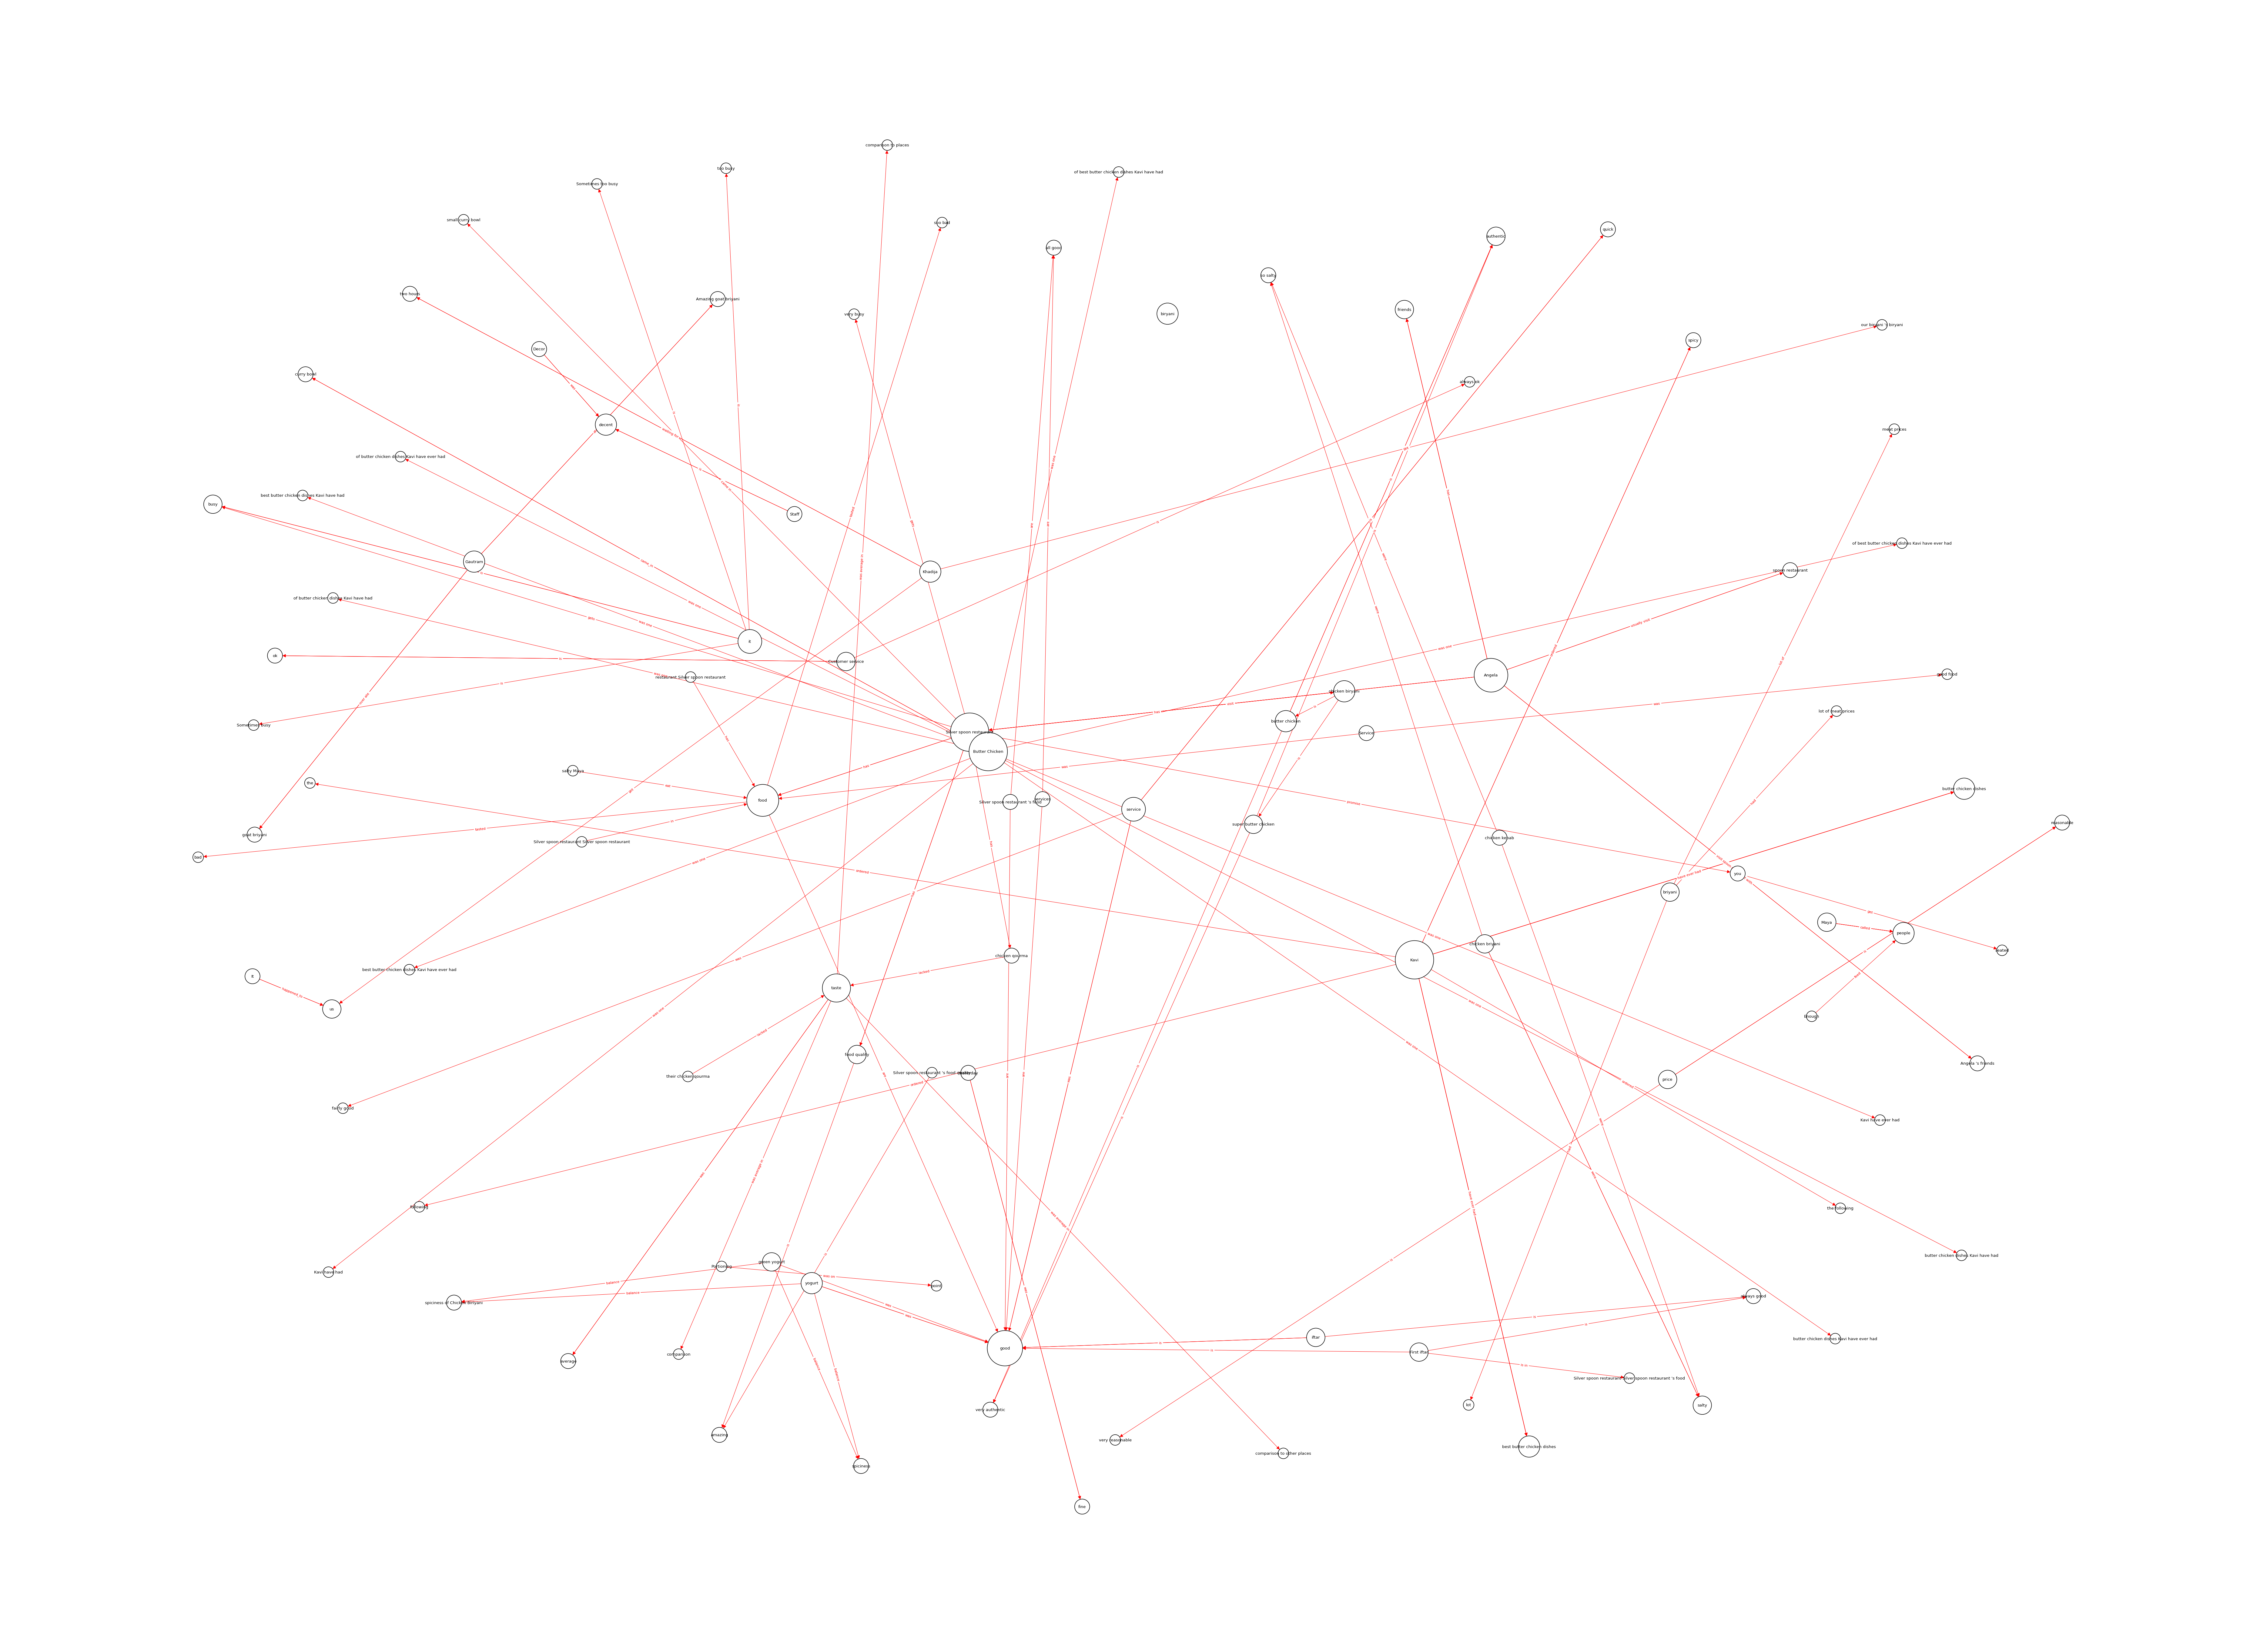

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [32]:
## Relation extraction

from openie import StanfordOpenIE
from information_extraction import split_sentence, get_lexical_triplets_pairs

with StanfordOpenIE() as client:
    
    for restaurant in restaurants:
        if restaurant["reviews"] and len(restaurant["reviews"]) > 0:

            triples = []
            for review in restaurant["reviews"]:

                text = review["review"]
                # print('Text: %s.' % text)

                sentences = split_sentence(text)

                
                for sentence in sentences:
                    # print("processing sentence: ")
                    # print(sentence)

                    for triple in client.annotate(str(sentence)):
                        tri = []

                        # print('|-', triple)
                        tri.append(triple.get("subject"))
                        tri.append(triple.get("relation"))
                        tri.append(triple.get("object"))
                        triples.append(tri)

                # print(triples)

                tuple_pairs = get_lexical_triplets_pairs(text)
                pairs = list(set(tuple(sub) for sub in tuple_pairs))
                # pairs.append(['silver spoon restaurant','like','chicken biryani'])
                # pairs.append(['services', 'are', 'good'])
                triples.extend(pairs)



            df = pd.DataFrame(triples, columns=['subject', 'relation', 'object'])
            print(df)
            df.to_csv("../data/output/kg/input_data.txt-out.csv", index=False)
            from create_kg import draw_kg
            draw_kg(df)

            graph = list()
            graph.append('digraph {')
            for er in pairs:
                graph.append('"{}" -> "{}" [ label="{}" ];'.format(er[0], er[2], er[1]))
            graph.append('}')
            graph_image = 'graph.png'
            import os
            from subprocess import Popen
            from sys import stderr
            output_dir = os.path.join('.', os.path.dirname(graph_image))
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)

            import tempfile
            out_dot = os.path.join(tempfile.gettempdir(), 'graph.dot')
            with open(out_dot, 'w') as output_file:
                output_file.writelines(graph)

            command = 'dot -Tpng {} -o {}'.format(out_dot, graph_image)
            dot_process = Popen(command, stdout=stderr, shell=True)
            dot_process.wait()
            assert not dot_process.returncode, 'ERROR: Call to dot exited with a non-zero code status.'

            # graph_image = 'graph.png'
            # client.generate_graphviz_graph(text, graph_image)
            # print('Graph generated: %s.' % graph_image)

In [36]:
import os, sys
sys.path.append("../")

from information_extraction import triple_pruning

# Perform pruning with Named Entity and Triple matching
triple_df = triple_pruning(triples=triples, ner_dict=ner_dict)
print('***** Completed Pruning *****')

ImportError: cannot import name 'triple_pruning' from 'information_extraction' (../information_extraction.py)

In [34]:
review = ["For all you west side kids, Pai has a location in Etobicoke delivering through apps.",
         "Location: Pai Etobicoke",
          "Delivery: UberEats",
          "I had to write my review before my words are slowly fleeting away.",
          "Ordered Khao Soi, coconut curry egg noodle, one tofu/veggie and one beef.",
          "Beef Khao Soi. There are 5-6 large chunks of beef.",
          "Tofu/Veggie Khao Soi.",
          "Broccoli and cauliflower were overcooked and broke upon touch.",
          "Despite the overcooked vegetables, the coconut curry was so rich, creamy, and flavourful.",
          "The egg noodle was a smaller portion than expected;",
          "the broth to noodle ratio was really skewed in the broth's favour.",
          "I really appreciated the following: Lime/green onions were packed into a small Dixie cup container.",
          "Fried noodles were plentiful, a whole sandwich bag full.",
          "Egg noodles were perfectly cooked and packed into a small round container.",
          "Would 100% reorder with a slight hope for non-overcooked broccoli and cauliflower.",
          "I hope the Pai Etobicoke location allows dine in once we return to a semi normalcy in the not so distant future."
         ]

doc = nlp_small(review[0])

for tok in doc:
    print(tok.text, "...", tok.dep_)

For ... prep
all ... det
you ... nmod
west ... compound
side ... compound
kids ... pobj
, ... punct
Pai ... nsubj
has ... ROOT
a ... det
location ... dobj
in ... prep
Etobicoke ... pobj
delivering ... acl
through ... prep
apps ... pobj
. ... punct


In [37]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp_small(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
          # check: token is a compound word or not
          if tok.dep_ == "compound":
            prefix = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                prefix = prv_tok_text + " "+ tok.text

          # check: token is a modifier or not
          if tok.dep_.endswith("mod") == True:
            modifier = tok.text
            # if the previous word was also a 'compound' then add the current word to it
            if prv_tok_dep == "compound":
                modifier = prv_tok_text + " "+ tok.text

          ## chunk 3
          if tok.dep_.find("subj") == True:
            ent1 = modifier +" "+ prefix + " "+ tok.text
            prefix = ""
            modifier = ""
            prv_tok_dep = ""
            prv_tok_text = ""      

          ## chunk 4
          if tok.dep_.find("obj") == True:
            ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5  
      # update variables
        prv_tok_dep = tok.dep_
        prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [38]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [39]:
get_entities(review[0])

['you west side Pai', 'apps']

In [40]:
entity_pairs = []

for i in tqdm(review):
    entitiy_pair = get_entities(i)
    if entitiy_pair[0] != '' and entitiy_pair[1] != '':
        entity_pairs.append(entitiy_pair)

100%|██████████| 16/16 [00:00<00:00, 48.97it/s]


In [41]:
entity_pairs[:]

[['you west side Pai', 'apps'],
 ['words', 'review'],
 ['Broccoli', 'touch'],
 ['overcooked coconut curry', 'overcooked  vegetables'],
 ['broth', 'really noodle favour'],
 ['green  onions', 'small Dixie cup container'],
 ['Egg noodles', 'round  container'],
 ['we', 'distant semi future']]

In [46]:
def get_relation(sent):

    doc = nlp_small(sent)

    # Matcher class object 
    matcher = Matcher(nlp_small.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", None, pattern) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [47]:
get_relation("John completed the task")

'completed'

In [48]:
relations = [get_relation(i) for i in tqdm(review)]

100%|██████████| 16/16 [00:00<00:00, 41.45it/s]


In [49]:
pd.Series(relations).value_counts()[:50]

was               3
Soi               2
has               1
Etobicoke         1
Delivery          1
had               1
are               1
overcooked        1
appreciated       1
were plentiful    1
cooked            1
reorder with      1
hope              1
dtype: int64

In [51]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

ValueError: All arrays must be of the same length